In [23]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import matplotlib.pyplot as plt

%matplotlib notebook

Loading BokehJS ...

## Define the dynamic logistic regression model

In [42]:
behavior_inference_model_code = """
data {
  int N;
  int y[N];
  vector[N] g1;
  vector[N] g2;
  vector[N] g3;
  vector[N] g4;
}


parameters {
  vector[N] n1;
  vector[N] n2;
  vector[N] n3;
  vector[N] n4;
}


transformed parameters {
  vector[N] evidence;
  vector<lower=0.0, upper=1>[N] prob;
  
  vector[N] w1;
  vector[N] w2;
  vector[N] w3;
  vector[N] w4;
  
  w1[1] = n1[1];
  w2[1] = n2[1];
  w3[1] = n3[1];
  w4[1] = n4[1];
  
  for (i in 2:N) {
    w1[i] = w1[i-1] + n1[i];
    w2[i] = w2[i-1] + n2[i];
    w3[i] = w3[i-1] + n3[i];
    w4[i] = w4[i-1] + n4[i];
  }
  
  evidence = g1 .* w1 + g2 .* w2 + g3 .* w3 + g4 .* w4;
  prob = 1.0 ./ (1.0 + exp(-evidence));
  
  // Constrain prob to be not too high and not too low
  prob = prob * 0.998 + 0.001;
}

model {
  // Priors
  //print(1, target())
  n1[1] ~ normal(0, 16);
  n2[1] ~ normal(0, 16);
  n3[1] ~ normal(0, 16);
  n4[1] ~ normal(0, 16);

  for (i in 2:N) {
    n1[i] ~ normal(0, 1.0/32);
    n2[i] ~ normal(0, 1.0/64);
    n3[i] ~ normal(0, 1.0/128);
    n4[i] ~ normal(0, 1.0/64);
  }
  //print(1, prob);
  //print(2, target());
  // Likelihood
  y ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91c32871dc64611e62c4e8e8fe8c30f0 NOW.


## Generate fake data to test the inference

In [58]:
# Fake data for simple inference
#np.random.seed(12334)
N = 5000
sigma1 = 1 / 32
sigma2 = 1 / 64
sigma3 = 1 / 128
sigma4 = 1 / 64
sigmaG = 1

n1 = np.random.normal(0, sigma1, size=N)
n2 = np.random.normal(0, sigma2, size=N)
n3 = np.random.normal(0, sigma3, size=N)
n4 = np.random.normal(0, sigma4, size=N)

w1 = np.cumsum(n1) + np.random.normal(0, 2)
w2 = np.cumsum(n2) + np.random.normal(0, 2)
w3 = np.cumsum(n3) + np.random.normal(0, 2)
w4 = np.cumsum(n4) + np.random.normal(0, 2)

g1 = np.random.normal(0, sigmaG, size=N)
g2 = np.random.normal(0, sigmaG, size=N)
g3 = np.random.normal(0, sigmaG, size=N)
g4 = np.random.normal(0, sigmaG, size=N)

evidence = g1 * w1 + g2 * w2 + g3 * w3 + g4 * w4;
prob = 1.0/(1.0 + np.exp(-evidence))
prob = prob * 0.998 + 0.001
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

<IPython.core.display.Javascript object>


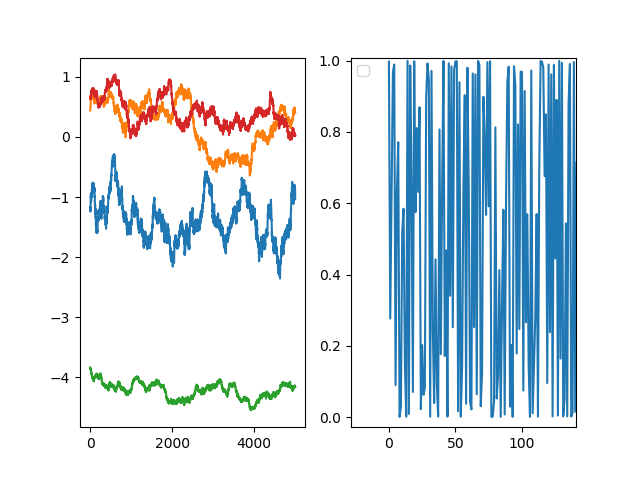

In [59]:
plt.figure()
plt.subplot(121)
plt.plot(w1, label='w1')
plt.plot(w2, label='w2')
plt.plot(w3, label='w3')
plt.plot(w4, label='w4')
plt.subplot(122)
plt.plot(prob)
plt.legend()

## Perform the sampling from the posterior

In [60]:
data_inf = dict(N=N,
               y=yvals.astype('int'),
               g1=g1,
               g2=g2, g3=g3, g4=g4)

init_prob = [dict(prob=np.ones(N) * 0.1)] * 4
samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=100, iter=300, control={'max_treedepth':18}, init=init_prob)

<IPython.core.display.Javascript object>


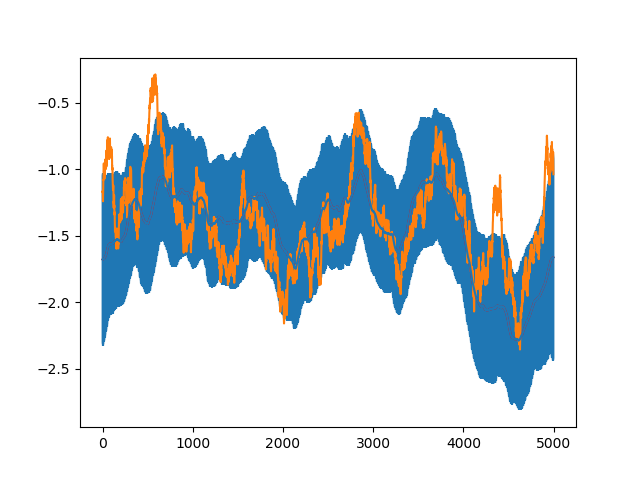

In [64]:
# Get samples of w1 and plot
n1samp = samples_beh_inf['w1']
means = np.mean(n1samp, axis=0)
std = np.std(n1samp, axis=0)
plt.figure(5)

plt.errorbar(np.arange(N), means, 1.96 * std)
plt.plot(means, 'r')
plt.plot(w1)

## Diagnostics

In [65]:
bebi103.stan.check_all_diagnostics(samples_beh_inf)

n_eff / iter looks reasonable for all parameters.
Rhat for parameter n1[1] is 1.5650032404321719.
Rhat for parameter n2[1] is 1.2890449257850716.
Rhat for parameter n3[1] is 1.3196552655963103.
Rhat for parameter n4[1] is 1.2584806793633994.
Rhat for parameter evidence[1] is 1.1983864612059298.
Rhat for parameter evidence[2] is 1.2168612896927402.
Rhat for parameter evidence[3] is 1.2390197938397043.
Rhat for parameter evidence[4] is 1.271668572614559.
Rhat for parameter evidence[5] is 1.503382485718504.
Rhat for parameter evidence[6] is 1.385058745704266.
Rhat for parameter evidence[7] is 1.289028409275318.
Rhat for parameter evidence[8] is 1.4471313494987563.
Rhat for parameter evidence[9] is 1.2580325617584736.
Rhat for parameter evidence[10] is 1.4289082073296797.
Rhat for parameter evidence[11] is 1.1887046473612854.
Rhat for parameter evidence[12] is 1.3760691643341851.
Rhat for parameter evidence[13] is 1.4895184105897903.
Rhat for parameter evidence[14] is 1.170735999950659.
Rh

Rhat for parameter evidence[190] is 1.1178891448488468.
Rhat for parameter evidence[191] is 1.1428741670083713.
Rhat for parameter evidence[195] is 1.1310612862737712.
Rhat for parameter evidence[198] is 1.2187581604884106.
Rhat for parameter evidence[200] is 1.2150674624539342.
Rhat for parameter evidence[206] is 1.1697007870053076.
Rhat for parameter evidence[208] is 1.1532890499776194.
Rhat for parameter evidence[216] is 1.1566178883905727.
Rhat for parameter evidence[217] is 1.1110288725595798.
Rhat for parameter evidence[218] is 1.1204571940877548.
Rhat for parameter evidence[219] is 1.1173748676787791.
Rhat for parameter evidence[227] is 1.217355971933505.
Rhat for parameter evidence[231] is 1.2029562405443603.
Rhat for parameter evidence[237] is 1.1221350642106844.
Rhat for parameter evidence[239] is 1.1591786175736685.
Rhat for parameter evidence[240] is 1.1749728895951592.
Rhat for parameter evidence[241] is 1.1513563031154939.
Rhat for parameter evidence[244] is 1.13198267258

Rhat for parameter prob[86] is 1.16010090417543.
Rhat for parameter prob[88] is 1.1900969936621297.
Rhat for parameter prob[89] is 1.1416640638760849.
Rhat for parameter prob[90] is 1.1662100693911888.
Rhat for parameter prob[91] is 1.1878902525752004.
Rhat for parameter prob[92] is 1.1492863838692435.
Rhat for parameter prob[94] is 1.1404568242916158.
Rhat for parameter prob[96] is 1.1146641231013434.
Rhat for parameter prob[98] is 1.2003317712376087.
Rhat for parameter prob[102] is 1.1723891128697062.
Rhat for parameter prob[103] is 1.1577614996507224.
Rhat for parameter prob[105] is 1.1011714864002498.
Rhat for parameter prob[106] is 1.1231704531260298.
Rhat for parameter prob[107] is 1.1198658546758296.
Rhat for parameter prob[108] is 1.1760337202383695.
Rhat for parameter prob[110] is 1.1170657890513767.
Rhat for parameter prob[111] is 1.1308870282670895.
Rhat for parameter prob[114] is 1.176046110638605.
Rhat for parameter prob[115] is 1.1286841271688555.
Rhat for parameter prob[

Rhat for parameter w1[72] is 1.1409645150882024.
Rhat for parameter w1[73] is 1.1429029434343578.
Rhat for parameter w1[74] is 1.1372601959424853.
Rhat for parameter w1[75] is 1.1412397642773573.
Rhat for parameter w1[76] is 1.1368851525729387.
Rhat for parameter w1[77] is 1.1342457398478354.
Rhat for parameter w1[78] is 1.1342367285079964.
Rhat for parameter w1[79] is 1.1364004927030278.
Rhat for parameter w1[80] is 1.1338168274029452.
Rhat for parameter w1[81] is 1.128494096018982.
Rhat for parameter w1[82] is 1.1264175433511545.
Rhat for parameter w1[83] is 1.1245147855788964.
Rhat for parameter w1[84] is 1.119996519491827.
Rhat for parameter w1[85] is 1.1149651067883697.
Rhat for parameter w1[86] is 1.112290878537617.
Rhat for parameter w1[87] is 1.1110582109256426.
Rhat for parameter w1[88] is 1.1057884923221133.
Rhat for parameter w1[89] is 1.1017960212743643.
Rhat for parameter w1[90] is 1.100532027202882.
Rhat for parameter w2[1] is 1.2890449257850716.
Rhat for parameter w2[2] 

Rhat for parameter w3[23] is 1.3029079915776922.
Rhat for parameter w3[24] is 1.3036292177695883.
Rhat for parameter w3[25] is 1.3042149619250898.
Rhat for parameter w3[26] is 1.3030261146918185.
Rhat for parameter w3[27] is 1.3013700186154404.
Rhat for parameter w3[28] is 1.3018038023474072.
Rhat for parameter w3[29] is 1.302541683089696.
Rhat for parameter w3[30] is 1.3034007571446058.
Rhat for parameter w3[31] is 1.304651484237273.
Rhat for parameter w3[32] is 1.3017683043259858.
Rhat for parameter w3[33] is 1.3007284682054479.
Rhat for parameter w3[34] is 1.297951124620738.
Rhat for parameter w3[35] is 1.2975941083916533.
Rhat for parameter w3[36] is 1.2979883385010145.
Rhat for parameter w3[37] is 1.297288959937553.
Rhat for parameter w3[38] is 1.2999857054195667.
Rhat for parameter w3[39] is 1.3003868848968956.
Rhat for parameter w3[40] is 1.2991480115676972.
Rhat for parameter w3[41] is 1.297591413831241.
Rhat for parameter w3[42] is 1.2967904268593955.
Rhat for parameter w3[43]

Rhat for parameter w3[189] is 1.2250892270632447.
Rhat for parameter w3[190] is 1.2240111930104085.
Rhat for parameter w3[191] is 1.2241544693903008.
Rhat for parameter w3[192] is 1.223521184626437.
Rhat for parameter w3[193] is 1.2259542491446023.
Rhat for parameter w3[194] is 1.2258613896952495.
Rhat for parameter w3[195] is 1.22434328644047.
Rhat for parameter w3[196] is 1.223605448678074.
Rhat for parameter w3[197] is 1.2216966265706872.
Rhat for parameter w3[198] is 1.2202628481633149.
Rhat for parameter w3[199] is 1.2182295396085572.
Rhat for parameter w3[200] is 1.2165214772009918.
Rhat for parameter w3[201] is 1.2173448448391686.
Rhat for parameter w3[202] is 1.2156387726180051.
Rhat for parameter w3[203] is 1.2144058808452731.
Rhat for parameter w3[204] is 1.2147493666291744.
Rhat for parameter w3[205] is 1.214349011929348.
Rhat for parameter w3[206] is 1.2131834169286957.
Rhat for parameter w3[207] is 1.2154553746141115.
Rhat for parameter w3[208] is 1.2146615196731108.
Rhat 

Rhat for parameter w3[353] is 1.1772211376886845.
Rhat for parameter w3[354] is 1.175916549237865.
Rhat for parameter w3[355] is 1.1756722885328363.
Rhat for parameter w3[356] is 1.1765308006784827.
Rhat for parameter w3[357] is 1.1765253225429113.
Rhat for parameter w3[358] is 1.175427237593279.
Rhat for parameter w3[359] is 1.1754461848349658.
Rhat for parameter w3[360] is 1.176129864809027.
Rhat for parameter w3[361] is 1.1769483408493713.
Rhat for parameter w3[362] is 1.1748651917578452.
Rhat for parameter w3[363] is 1.1747656816946839.
Rhat for parameter w3[364] is 1.173529412429428.
Rhat for parameter w3[365] is 1.1734131852122403.
Rhat for parameter w3[366] is 1.1725725999445689.
Rhat for parameter w3[367] is 1.1733878717139872.
Rhat for parameter w3[368] is 1.1717679175980766.
Rhat for parameter w3[369] is 1.170813651751373.
Rhat for parameter w3[370] is 1.169334106376541.
Rhat for parameter w3[371] is 1.1675259762231445.
Rhat for parameter w3[372] is 1.1665538461530316.
Rhat f

Rhat for parameter w3[517] is 1.1374951349682938.
Rhat for parameter w3[518] is 1.1370639196672603.
Rhat for parameter w3[519] is 1.13801100149629.
Rhat for parameter w3[520] is 1.1365370960372252.
Rhat for parameter w3[521] is 1.1384495940520687.
Rhat for parameter w3[522] is 1.1371056812181515.
Rhat for parameter w3[523] is 1.1375308642421105.
Rhat for parameter w3[524] is 1.135622342823662.
Rhat for parameter w3[525] is 1.1356475632262975.
Rhat for parameter w3[526] is 1.134910280944433.
Rhat for parameter w3[527] is 1.1332788550460797.
Rhat for parameter w3[528] is 1.1334510855766056.
Rhat for parameter w3[529] is 1.1321439073363522.
Rhat for parameter w3[530] is 1.1333799888007345.
Rhat for parameter w3[531] is 1.1324154137463005.
Rhat for parameter w3[532] is 1.1325281446404543.
Rhat for parameter w3[533] is 1.1332024552661866.
Rhat for parameter w3[534] is 1.1328833639038813.
Rhat for parameter w3[535] is 1.1319675912203444.
Rhat for parameter w3[536] is 1.1312520977944798.
Rhat

Rhat for parameter w3[681] is 1.1092037340304766.
Rhat for parameter w3[682] is 1.1086631457845852.
Rhat for parameter w3[683] is 1.1077192328556544.
Rhat for parameter w3[684] is 1.1068882104465616.
Rhat for parameter w3[685] is 1.1052241684486548.
Rhat for parameter w3[686] is 1.1051024215020742.
Rhat for parameter w3[687] is 1.1054963508360853.
Rhat for parameter w3[688] is 1.1052549165213985.
Rhat for parameter w3[689] is 1.1045410702554217.
Rhat for parameter w3[690] is 1.1031153806798129.
Rhat for parameter w3[691] is 1.1018084778102837.
Rhat for parameter w3[692] is 1.1015219769187332.
Rhat for parameter w3[693] is 1.1008507773562843.
Rhat for parameter w4[1] is 1.2584806793633994.
Rhat for parameter w4[2] is 1.2572442502504553.
Rhat for parameter w4[3] is 1.2578855195370313.
Rhat for parameter w4[4] is 1.255595734921758.
Rhat for parameter w4[5] is 1.2549181778395109.
Rhat for parameter w4[6] is 1.2536656951417433.
Rhat for parameter w4[7] is 1.251890754423973.
Rhat for paramet

2

In [66]:
transformation = lambda x: (x - np.mean(x)) / np.std(x)

bokeh.io.show(bebi103.viz.parcoord_plot(samples_beh_inf, 
                                        transformation=transformation, 
                                        pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                       divergence_alpha=0.1, 
                                        divergence_line_width=0.5))

In [67]:
bokeh.io.show(bebi103.viz.trace_plot(samples_beh_inf, 
                                     pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'], 
                                     inc_warmup=True))

In [68]:
bokeh.io.show(bebi103.viz.corner(samples_beh_inf, 
                                 pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                 labels=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]']))